In [149]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
import pandas as pd
from scipy import stats
import math
from scipy.stats.stats import pearsonr
pd.options.mode.chained_assignment = None  # default='warn'

In [150]:
events_data=pd.read_csv('event_data_train.csv')
events_data['date']=pd.to_datetime(events_data.timestamp,unit='s')
submissions_data=pd.read_csv('submissions_data_train.csv')
submissions_data['date']=pd.to_datetime(submissions_data.timestamp,unit='s')

In [151]:
events_data.head(-1)

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35
...,...,...,...,...,...
3480697,33375,1526772685,discovered,11677,2018-05-19 23:31:25
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30


In [152]:
events_data['day']=events_data.date.dt.date
submissions_data['day']=submissions_data.date.dt.date

In [153]:
events_data.user_id.nunique()

19234

Число уникальных пользователей

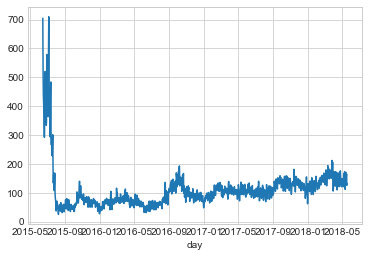

In [154]:
events_data.groupby('day').user_id.nunique().plot()

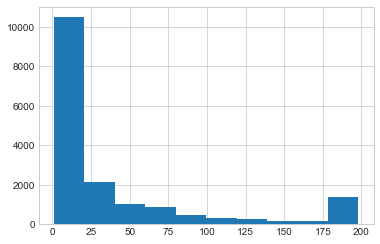

In [155]:
events_data[events_data.action=="passed"].groupby('user_id', as_index=False).agg({'step_id':'count'})\
.rename(columns={'step_id':'passed'}).passed.hist()

In [30]:
events_data[events_data.action=="passed"].groupby('user_id', as_index=False).agg({'step_id':'count'})\
.rename(columns={'step_id':'passed'}).user_id.nunique()

17262

Куда 2000 потерялись??

In [127]:
user_events_data=events_data.pivot_table(index='user_id',columns='action', values='step_id',aggfunc='count',fill_value=0)\
.reset_index()

In [128]:
user_events_data

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1
...,...,...,...,...,...
19229,26790,8,8,1,9
19230,26793,1,0,1,1
19231,26794,69,69,34,180
19232,26797,10,10,2,13


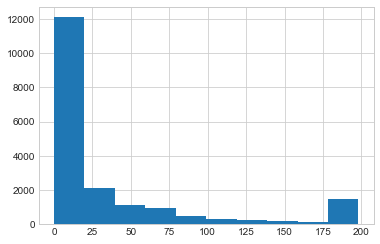

In [123]:
events_data.pivot_table(index='user_id',columns='action', values='step_id',aggfunc='count',fill_value=0)\
.reset_index().discovered.hist()

Вот тут уже ничего не потерялось

In [156]:
submissions_data

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15
...,...,...,...,...,...,...
509099,120745,1501946959,wrong,2615,2017-08-05 15:29:19,2017-08-05
509100,120745,1503059927,correct,13177,2017-08-18 12:38:47,2017-08-18
509101,120745,1506348153,wrong,15253,2017-09-25 14:02:33,2017-09-25
509102,120745,1523035316,wrong,1424,2018-04-06 17:21:56,2018-04-06


In [157]:
user_scores=submissions_data.pivot_table(index='user_id',
                                         columns='submission_status',
                                         values='step_id',
                                         aggfunc='count',fill_value=0).reset_index()
user_scores

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1
...,...,...,...
9935,26787,3,0
9936,26790,1,0
9937,26794,33,9
9938,26797,2,0


In [158]:
events_data[['user_id','day','timestamp']].drop_duplicates(subset=['user_id','day'])

,user_id,day,timestamp
0,17632,2015-06-15,1434340848
36,12494,2015-06-15,1434341931
59,442,2015-06-15,1434342029
62,22254,2015-06-15,1434342042
94,6646,2015-06-15,1434342230
...,...,...,...
3480298,364,2018-05-19,1526762223
3480329,22851,2018-05-19,1526762629
3480333,943,2018-05-19,1526762664
3480669,26659,2018-05-19,1526770439


In [159]:
gaps=events_data[['user_id','day','timestamp']].drop_duplicates(subset=['user_id','day']) \
    .groupby('user_id')['timestamp'].apply(list).apply(np.diff).values
#Считаем промежутки между двумя заходами на курс

In [160]:
gaps=pd.Series(np.concatenate(gaps,axis=0))

In [96]:
gaps #тут все промежутки между заходами

0         4843602
1         6899249
2          182484
3           93710
4         2768870
           ...   
97867    14347289
97868      505061
97869       98252
97870       57019
97871     1567990
Length: 97872, dtype: int64

In [161]:
timestamp=30*24*60*60

In [162]:
gaps.quantile(0.95) # только 5% пользователей возвращаются через 2 месяца

5163302.099999994

In [163]:
gaps.quantile(0.90)/(24*60*60)

18.325995370370403

In [164]:
events_data.groupby('user_id')['day'].nunique().sort_values(ascending=False)
# ищем карпова

user_id
1046     478
13268    385
4374     327
10794    281
3572     236
        ... 
14880      1
14878      1
14875      1
14873      1
1          1
Name: day, Length: 19234, dtype: int64

In [165]:
users_data=events_data.groupby('user_id',as_index=False).agg({'timestamp':'max'}).rename(columns=({'timestamp':'max_timestamp'}))

In [167]:
users_data

,user_id,max_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660
...,...,...
19229,26790,1517495987
19230,26793,1510225034
19231,26794,1512035039
19232,26797,1509995096


In [168]:
now=1526772750
drop_out=2592000

In [176]:
users_data['is_gone']=(now-users_data.max_timestamp)>drop_out

In [178]:
users_data=users_data.merge(user_scores,how='outer')

In [179]:
users_data=users_data.fillna(0) # слепили две таблички с очками и ту ушел ли юзер или нет?

In [180]:
users_data

,user_id,max_timestamp,is_gone,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1
...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9
19230,26793,1510225034,True,0.0,0.0,1,0,1,1
19231,26794,1512035039,True,33.0,9.0,69,69,34,180
19232,26797,1509995096,True,2.0,0.0,10,10,2,13


In [181]:
users_data=users_data.merge(user_events_data,how='outer') 
#теперь почти готовая табличка

In [182]:
users_days=events_data.groupby('user_id').day.nunique().to_frame().reset_index()
users_days
#считаем число уникальных дней на курсе

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1
...,...,...
19229,26790,4
19230,26793,1
19231,26794,9
19232,26797,2


In [183]:
users_data=users_data.merge(users_days,how='outer') 
users_data

,user_id,max_timestamp,is_gone,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4
19230,26793,1510225034,True,0.0,0.0,1,0,1,1,1
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2


Никто не потерялся

In [184]:
users_data['passed_course']=users_data.passed>170

In [145]:
users_data

,user_id,max_timestamp,is_gone,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False
...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4,False
19230,26793,1510225034,True,0.0,0.0,1,0,1,1,1,False
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9,False
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2,False


In [186]:
users_data.groupby('passed_course').count()['user_id']

passed_course
False    17809
True      1425
Name: user_id, dtype: int64

In [200]:
users_data['day'][users_data.passed_course].median()

20.0

Медиана по дням - 20

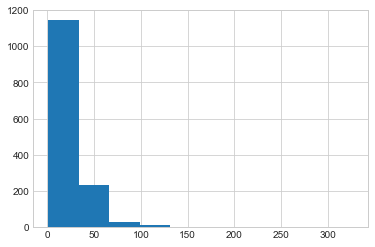

In [202]:
users_data['day'][users_data.passed_course].hist()

Совсем не нормальные данные

Готовим датасет и ищем первый день на курсе

In [207]:
user_min_time = events_data.groupby('user_id',as_index=False).agg({'timestamp':'min'})\
                        .rename({'timestamp':'min_timestamp'},axis=1)
user_min_time

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660
...,...,...
19229,26790,1451484016
19230,26793,1510225031
19231,26794,1495287049
19232,26797,1508425316


In [209]:
users_data=users_data.merge(user_min_time,how='outer')
users_data

,user_id,max_timestamp,is_gone,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660
...,...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4,False,1451484016
19230,26793,1510225034,True,0.0,0.0,1,0,1,1,1,False,1510225031
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9,False,1495287049
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2,False,1508425316


теперь надо отобрать действия каждого пользователя за три дня.

In [265]:
time_threshold=3*24*60*60
events_data_modified=events_data.merge(user_min_time, on='user_id', how='outer')
events_data_train=events_data_modified[events_data_modified.timestamp<events_data_modified.min_timestamp+time_threshold]
events_data_train



,step_id,timestamp,action,user_id,date,day,min_timestamp
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848
...,...,...,...,...,...,...,...
3480698,32814,1526762783,discovered,943,2018-05-19 20:46:23,2018-05-19,1526762664
3480699,32814,1526762783,passed,943,2018-05-19 20:46:23,2018-05-19,1526762664
3480700,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19,1526772750
3480701,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19,1526772750


In [268]:
submissions_data_modified=submissions_data.merge(user_min_time, on='user_id', how='outer')
submissions_data_train=submissions_data_modified[submissions_data_modified.timestamp<submissions_data_modified.min_timestamp+time_threshold]
submissions_data_train.groupby('user_id').day.nunique().max() # тут проверочка на дни

4

подзадачка: найти самый сложный степ после которого юзер уходил

In [260]:
hard_step=events_data.groupby('user_id',as_index=False).agg({'timestamp':'max'})\
                        .merge(submissions_data, on=['user_id','timestamp'],how='outer').dropna()\
                        .groupby('step_id').apply(lambda x: x[x.submission_status=='wrong'].count())\
                        .sort_values('submission_status',ascending=False)
hard_step

,user_id,timestamp,step_id,submission_status,date,day
step_id,,,,,,
31978.0,16084,16084,16084,16084,16084,16084
32031.0,13373,13373,13373,13373,13373,13373
32202.0,13002,13002,13002,13002,13002,13002
33481.0,10300,10300,10300,10300,10300,10300
32075.0,10003,10003,10003,10003,10003,10003
...,...,...,...,...,...,...
33482.0,707,707,707,707,707,707
33681.0,703,703,703,703,703,703
33362.0,673,673,673,673,673,673


In [300]:
events_data_train.groupby('user_id').day.nunique().max()

4

Проверка это важно!!!!!

In [374]:
X = submissions_data_train.groupby('user_id').day.nunique().to_frame().reset_index().rename(columns={'day':'days'})

In [375]:
steps_tried=submissions_data_train.groupby('user_id').step_id.nunique().to_frame()\
                                    .reset_index().rename(columns={'step_id':'steps_tried'})

In [376]:
X=X.merge(steps_tried,on='user_id',how='outer')


In [377]:
X=X.merge(submissions_data_train.pivot_table(index='user_id',
                                             columns='submission_status',
                                             values='step_id',
                                             aggfunc='count',
                                             fill_value=0).reset_index(),on='user_id',how='outer')

In [378]:
X

,user_id,days,steps_tried,correct,wrong
0,2,1,2,2,0
1,3,1,4,4,4
2,8,1,11,9,21
3,14,1,1,0,1
4,16,3,23,23,27
...,...,...,...,...,...
8908,26787,1,3,3,0
8909,26790,1,1,1,0
8910,26794,3,27,31,9
8911,26797,1,2,2,0


In [379]:
X['correct_ratio']=X.correct/(X.correct+X.wrong)

In [380]:
X = X.merge(events_data.pivot_table(index='user_id',
                                    columns='action',
                                    values='step_id',
                                    aggfunc='count',fill_value=0).reset_index()[['user_id','viewed']],how='outer')

In [381]:
X=X.fillna(0)

In [382]:
X

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.00,10
1,3,1.0,4.0,4.0,4.0,0.50,192
2,8,1.0,11.0,9.0,21.0,0.30,156
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,651
...,...,...,...,...,...,...,...
19229,26774,0.0,0.0,0.0,0.0,0.00,1
19230,26781,0.0,0.0,0.0,0.0,0.00,698
19231,26788,0.0,0.0,0.0,0.0,0.00,1
19232,26789,0.0,0.0,0.0,0.0,0.00,2


In [383]:
X=X.merge(users_data[['user_id','passed_course','is_gone']],how='outer')

Нужно выкинуть лишние данные про пользователей которые еще не ушли но проходят курс

In [384]:
X=X[X.is_gone|X.passed_course]
X

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone
0,2,1.0,2.0,2.0,0.0,1.00,10,False,True
1,3,1.0,4.0,4.0,4.0,0.50,192,False,True
2,8,1.0,11.0,9.0,21.0,0.30,156,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,651,True,True
...,...,...,...,...,...,...,...,...,...
19229,26774,0.0,0.0,0.0,0.0,0.00,1,False,True
19230,26781,0.0,0.0,0.0,0.0,0.00,698,True,True
19231,26788,0.0,0.0,0.0,0.0,0.00,1,False,True
19232,26789,0.0,0.0,0.0,0.0,0.00,2,False,True


In [385]:
X.groupby(['passed_course','is_gone']).user_id.count()

passed_course  is_gone
False          True       16560
True           False        141
               True        1284
Name: user_id, dtype: int64

Целевая переменная - passed course

In [386]:
y=X.passed_course.map(int)

In [387]:
X=X.drop(['passed_course','is_gone'],axis=1).set_index(X.user_id)

In [388]:
X.drop(['user_id'],axis=1)

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,10
3,1.0,4.0,4.0,4.0,0.50,192
8,1.0,11.0,9.0,21.0,0.30,156
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,651
...,...,...,...,...,...,...
26774,0.0,0.0,0.0,0.0,0.00,1
26781,0.0,0.0,0.0,0.0,0.00,698
26788,0.0,0.0,0.0,0.0,0.00,1


Строим дерево выбора

In [422]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

X_train, X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)
params={'max_depth':range(1,10),
        'max_leaf_nodes': range(2,8),
        'min_samples_leaf': range(2,8),
        'min_samples_split': range(2,8)}
clf = tree.DecisionTreeClassifier(criterion='entropy')
search=GridSearchCV(clf,param_grid=params,cv=5)

search.fit(X_train,y_train)
print(search)
best_tree=search.best_estimator_
best_tree.score(X_train,y_train)
cross_val_score(best_tree,X_train,y_train,cv=5)

best_tree.score(X_test,y_test)
tree.plot_tree(best_tree, filled=True)


print(precision_score(y_test,best_tree.predict(X_test)),recall_score(y_test,best_tree.predict(X_test)))

In [427]:
best_tree.score(X_test,y_test)

0.9618235730170497

In [428]:
print(precision_score(y_test,best_tree.predict(X_test)),recall_score(y_test,best_tree.predict(X_test)))

0.6811594202898551 0.863517060367454
